In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs

from metpy.mapping.MPMap import MPMap
from metpy.mapping.points import *
from metpy.mapping.triangles import *
from metpy.mapping.tests.test_MPGridding import station_test_data

from scipy.spatial import Voronoi, Delaunay, ConvexHull, delaunay_plot_2d, voronoi_plot_2d
from scipy.spatial.distance import euclidean

from matplotlib.delaunay.triangulate import Triangulation

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

def plot_triangle(triangle):
    x = [triangle[0,0], triangle[1,0], triangle[2,0], triangle[0,0]]
    y = [triangle[0,1], triangle[1,1], triangle[2,1], triangle[0,1]]
    
    plt.plot(x, y, "k:", linewidth=3)

def calc_voronoi_lines(vor):
    
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            plt.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k--')

C:\Users\ahaberli\anaconda3\envs\unidata3\lib\site-packages\matplotlib\cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
xp, yp, temperature = station_test_data("air_temperature", from_proj, to_proj)

xg, yg = generate_grid(25000, 25000, get_boundary_coords(xp, yp))

bbox = get_boundary_coords(xp, yp)

grid_points = generate_grid_coords(xg, yg)

In [10]:
points = list(zip(xp, yp))

tri = Delaunay(points)
vor = Voronoi(points, incremental=True)
tri_match = tri.find_simplex(grid_points)


t = Triangulation(xp, yp)

cur_tri = tri_match[7759]
grid = grid_points[7759]

C:\Users\ahaberli\anaconda3\envs\unidata3\lib\site-packages\matplotlib\delaunay\triangulate.py:108: DuplicatePointWarning: Input data contains duplicate x,y points; some values are ignored.
  DuplicatePointWarning,


In [11]:
neighbors = find_nn_triangles(tri, cur_tri, grid)
new_tri = tri.simplices[neighbors]

print(neighbors)

edges = find_local_boundary(tri, neighbors)

ordered = order_edges(edges)

ordered = np.array(ordered)

[2324, 2322, 2323, 1428, 2321]


919 1367
1367 1119
1119 919
1276 1119
155 474
1102 155
1119 1102
897 1411
1411 1276
474 1066
1066 897


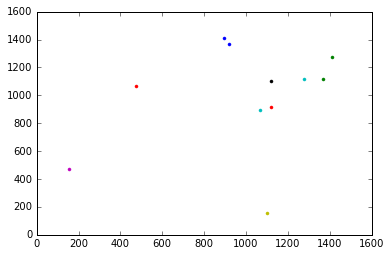

In [17]:
neighbors = [248, 486, 484, 491, 487, 50, 485]

new_tri = tri.simplices[neighbors]

edges = find_local_boundary(tri, neighbors)

for x,y in edges:
    print(x,y)
    plt.plot(x, y, ".")

[[  -71438.71216443  -976798.09045372]
 [ -125064.79271627  -995064.70891955]
 [  -49364.63125669  -997410.28244143]
 [  -66956.07118587 -1026268.27569822]
 [ -117364.63162898 -1008180.00255037]
 [  -71438.71216443  -976798.09045372]]
[[ -125064.79271627  -995064.70891955]
 [ -133841.49359674 -1009877.86640982]
 [ -117364.63162898 -1008180.00255037]
 [ -125064.79271627  -995064.70891955]]
[[ -133841.49359674 -1009877.86640982]
 [  -84164.64704587 -1090466.68707323]
 [  -66956.07118587 -1026268.27569822]
 [ -117364.63162898 -1008180.00255037]
 [  -71609.38374772 -1083080.1752825 ]
 [ -133841.49359674 -1009877.86640982]]
[[  -84164.64704587 -1090466.68707323]
 [  -66808.40824193 -1085971.02641089]
 [  -71609.38374772 -1083080.1752825 ]
 [  -84164.64704587 -1090466.68707323]]
[[  -66808.40824193 -1085971.02641089]
 [  -36196.20077707  -988804.14989479]
 [  -49364.63125669  -997410.28244143]
 [  -66956.07118587 -1026268.27569822]
 [  -37875.32614271  -988844.64695919]
 [  -71609.38374772 -

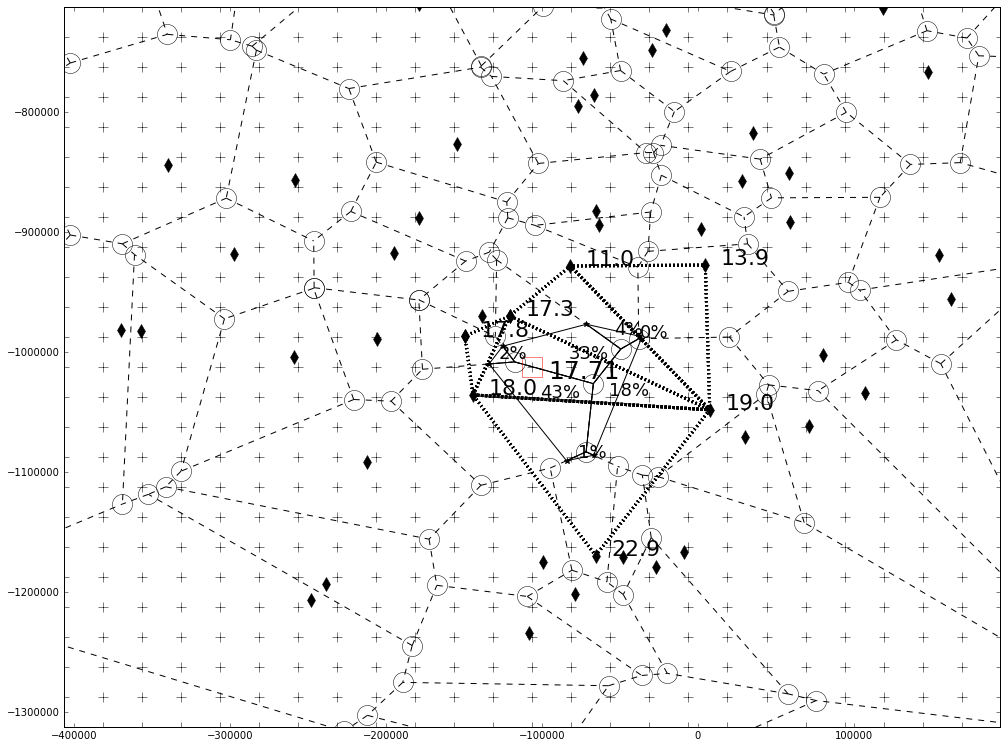

In [38]:
edge_vertices = np.array(tri.points[ordered[:,0]])

fig = plt.figure(figsize=(13,10))
    
ax = fig.add_axes([0, 0, 1, 1])

polygon_labels = []

if len(edge_vertices) > 0:
    
    area_list = []
    num_vertices = len(edge_vertices)
    for i in range(num_vertices):

        p1 = edge_vertices[i]
        p2 = edge_vertices[(i+1)%num_vertices]
        p3 = edge_vertices[(i+2)%num_vertices]

        polygon = []

        c1 = circumcenter(np.array([grid, p1, p2]))
        c2 = circumcenter(np.array([grid, p2, p3]))

        plt.plot([c1[0],c2[0]], [c1[1],c2[1]], 'k*')

        polygon.append(c1)
        polygon.append(c2)

        cur_match = 0
        for new in new_tri:
            points = tri.points[new]
            plot_triangle(points)
            if p2 in points:
                polygon.append(circumcenter(points))
                cur_match += 1

        polygon.append(c1)

        polygon = np.array(polygon)

        print(polygon)
        
        pts = polygon[ConvexHull(polygon).vertices]
        pts = np.concatenate((pts, [pts[0]]), axis=0)

        
        
        ax.plot(pts[:,0], pts[:,1], "k-")

        value = temperature[lookup_values(xp, yp, p2[0], p2[1])]


        ax.annotate(str(value[0]), xy=(p2[0]+10000, p2[1]), fontsize=22)
        
        area_list.append((value[0], area(pts)))
        
        x_temp = np.mean(pts[:,0])
        y_temp = np.mean(pts[:,1])
        
        polygon_labels.append((x_temp, y_temp, area(pts)))
        #plt.annotate("{0:.0f}%".format(100*area(pts)/7393025382.7946739), xy=(x_temp, y_temp), fontsize=18)

    area_list = np.array(area_list)

    total_area = np.sum(area_list[:,1])

    interp_value = np.sum(area_list[:,0] * (area_list[:,1]/total_area))

ax.plot(grid_points[:,0], grid_points[:,1], 'k+', markersize=10)
ax.plot(grid[0], grid[1], "rs", markersize=20, fillstyle='none')

ax.annotate('{0:.2f}'.format(interp_value), xy=(grid[0]+10000, grid[1]-10000), fontsize=25)

polygon_labels = np.array(polygon_labels)

for (x, y, val) in polygon_labels:
    
    ax.annotate("{0:.0f}%".format(100*val/total_area), xy=(x, y), fontsize=18)

plot_voronoi_lines(plt, vor)    
    
ax.plot(xp, yp, "kd", markersize=10)

xlow = grid[0] - 300000
xhigh = grid[0] + 300000
ylow = grid[1] - 300000
yhigh = grid[1] + 300000

ax.set_xlim(xlow, xhigh)
ax.set_ylim(ylow, yhigh)

ax.plot(t.circumcenters[:,0], t.circumcenters[:,1], "ko", markersize=20, fillstyle='none')

The following by-hand check might be slightly off due to rounding.

In [5]:
neighbor_vertices

array([[    7697.14483893, -1048110.75142627],
       [  -81663.85862506,  -928248.56067371],
       [ -120574.03667075,  -969918.38496153],
       [ -144168.56714557, -1035671.83228321],
       [    7697.14483893, -1048110.75142627],
       [ -120574.03667075,  -969918.38496153],
       [  -81663.85862506,  -928248.56067371],
       [    7697.14483893, -1048110.75142627],
       [    4787.06668732,  -927450.49831218],
       [ -149211.60169127,  -986731.87538065],
       [ -144168.56714557, -1035671.83228321],
       [ -120574.03667075,  -969918.38496153],
       [  -65415.6030428 , -1169532.60822617],
       [    7697.14483893, -1048110.75142627],
       [ -144168.56714557, -1035671.83228321]])